In [30]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X = X.to_numpy()

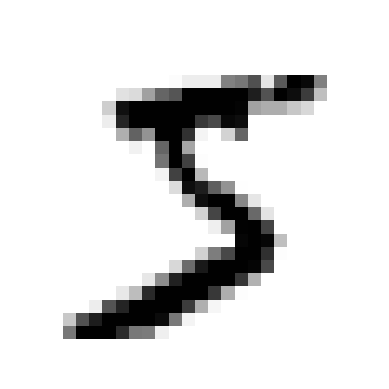

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [8]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9615
0.962
0.963


In [9]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.962 , 0.956 , 0.9665])

In [10]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
con_matrix = confusion_matrix(y_train_5, y_train_pred)

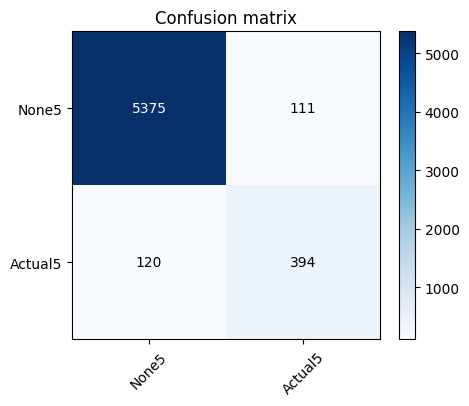

In [12]:
plt.figure(figsize=(5, 4))
cmap = plt.get_cmap('Blues')
plt.imshow(con_matrix, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
targets = np.array(['None5', 'Actual5'])
targets_pos = np.arange(len(targets))
plt.xticks(targets_pos, targets, rotation=45)
plt.yticks(targets_pos, targets)
thresh = con_matrix.max() / 2 #Umbral entre blanco y negro
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        plt.text(j , i, format(con_matrix[i, j], 'd'),
        ha='center', va='center', 
        color='white' if con_matrix[i, j] > thresh else 'black')

#5375 corrèctament classificats com a 'no 5'
#111 classificats com a '5' quan en realitat són 'no 5' (fals positiu)
#120 incorrèctament classificats com a 'no 5' (fals negatiu)
#394 corrèctament classificats com a '5'


In [13]:
print(precision_score(y_train_5, y_train_pred))
#Precision score : Falsos positivos costosos
#Precision score = TP / TP + FP
print(recall_score(y_train_5, y_train_pred))
#Recall score : Falsos negativos costosos
#Recall score = TP / TP + FN

0.7801980198019802
0.7665369649805448


In [14]:
f1_score(y_train_5, y_train_pred)
#Mitjana entre Precision score i recall score

0.7733071638861629

In [15]:
#Precision/Recall Trade Off
#El model calcula mitj. una funció de decissió que tant confiat està de que una mostra pertanyi a x classe
#Amb un umbral (threshold) que representa un valor, pot decantar o per un costat o per un altre. P.e. si l'umbral és 4 i tot allò
# >4 és True però el valor de la funció de decissió resulta ser 3, serà classificat com a False

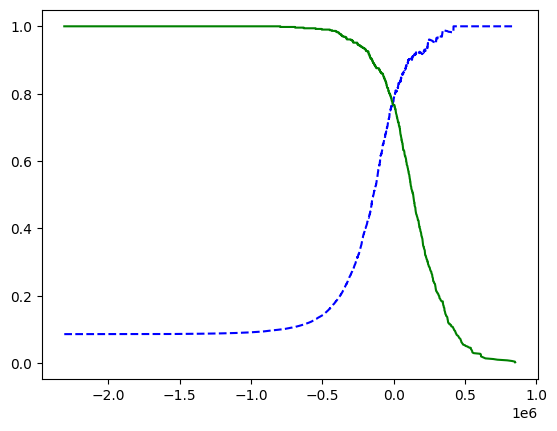

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [17]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9012345679012346
0.5680933852140078


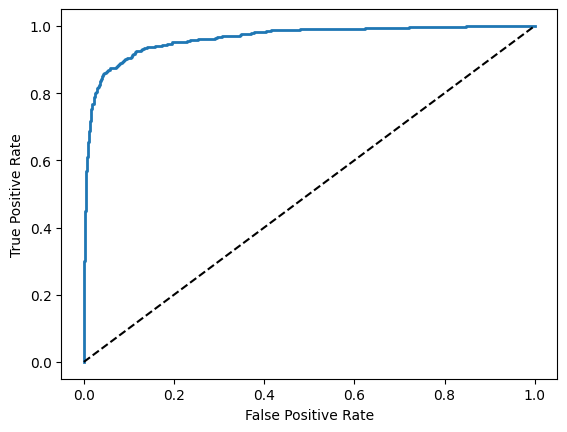

In [18]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1], [0,1], 'k--')


plot_roc_curve(fpr, tpr)
plt.show()

In [19]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9641599203348885)

In [20]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

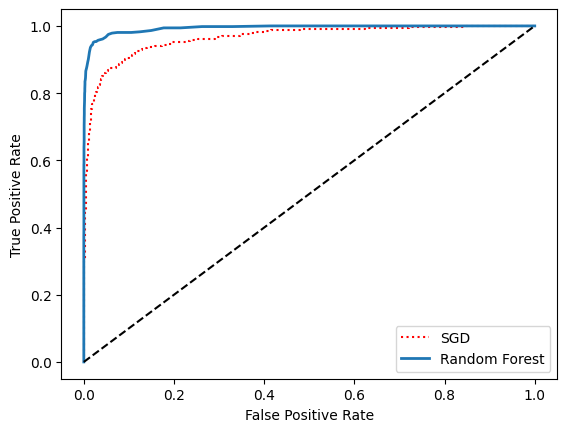

In [21]:
plt.plot(fpr, tpr, 'r:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [22]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9936162229715256)

In [23]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [24]:
some_digits_scores = svm_clf.decision_function([some_digit])
some_digits_scores

array([[ 1.74201669,  3.75934047,  6.18134457,  8.29644372, -0.30252035,
         9.30527336,  1.74930094,  2.77838477,  7.19221016,  3.87315474]])

In [25]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8705, 0.8985, 0.8925])

In [27]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[572,   0,   1,   2,   1,   9,   3,   1,   3,   0],
       [  0, 637,   6,   3,   1,   5,   0,   1,  16,   2],
       [ 10,  12, 493,  11,  10,   4,  10,   9,  20,   2],
       [  3,   5,  21, 514,   1,  35,   1,   7,  11,  10],
       [  3,   2,   7,   0, 556,   2,  10,   8,   9,  26],
       [  5,   6,   5,  24,  14, 411,  10,   1,  25,  13],
       [  4,   4,   6,   0,   5,   6, 577,   1,   5,   0],
       [  3,   4,   7,   2,   9,   0,   1, 577,   3,  45],
       [  2,  19,  13,  16,   4,  10,   6,   3, 464,  14],
       [  7,   4,   5,   7,  15,   3,   0,  27,  11, 522]])

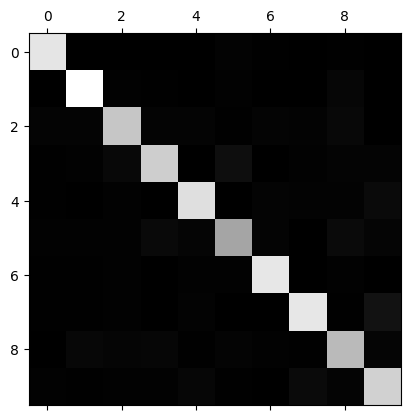

In [28]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

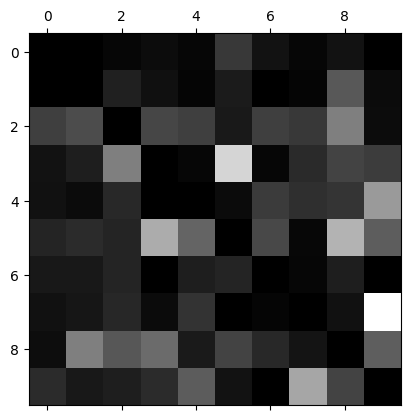

In [29]:
#Els números de la confusion matrix són absoluts, però per sapiguer el ratio d'error cal 
#primer de tot normalitzar.
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [31]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [35]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9500922726736858

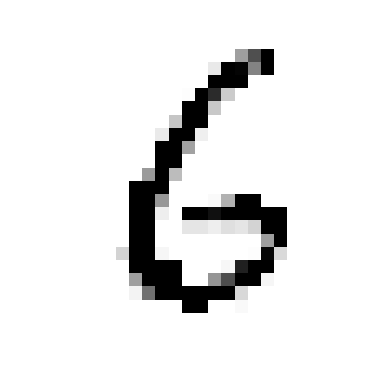

In [42]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
clean_digit_reshape = clean_digit.reshape(28, 28)
plt.imshow(clean_digit_reshape, cmap='binary')
plt.axis('off')
plt.show()